In [16]:
import requests
import pandas as pd
from datetime import datetime
import numpy as np
import xgboost as xgb
from sklearn.model_selection import train_test_split
from sklearn.metrics import precision_score, recall_score, confusion_matrix, ConfusionMatrixDisplay, accuracy_score, f1_score
import matplotlib.pyplot as plt
from datetime import datetime, timedelta
from xgboost_order import process_kline, inference
from helper import get_binance_ohlc_time, generate_date_list, calculate_rsi_with_ema, is_decrease, is_pin_bar


In [9]:
import random
def rule(df_btc, df, tp=1, sl=5, money=1000, model = None, num_random=10000, window_test=10, seq=30, time_pred=10, manual_cond=False):
    dfcopy = df.copy()
    number_high = 0
    number_low = 0
    cannot_break = 0
    results = []
    list_reward = []
    balance = 0
    price_line = []

    index_condition = []
    if model is None:
        index_condition = random.sample(range(100, len(df)), num_random)
    else:
        for i in range(seq+1, len(df)-1, window_test):
            x_array = df.loc[i-seq:i-1, ["open", "high", "low", "close", "volumn"]].to_numpy()
            x_array_cp = x_array.copy()
            rsi_6 = calculate_rsi_with_ema(x_array, 6)
            y_pred_prob = inference(x_array, model)
            if y_pred_prob == 1:
                if manual_cond:
                    # if is_decrease(x_array_cp[-1]) or is_decrease(x_array_cp[-2]) or is_pin_bar(x_array_cp[-1]): 
                    if rsi_6[-1] > 20 and rsi_6[-2] > 20:
                        index_condition.append(i)
                else:
                    index_condition.append(i)
    index_condition = sorted(index_condition)
    for i in index_condition:
        open_price_i = df['open'].iloc[i]
        high_check = False
        low_check = False
        open_time = df.iloc[i]['timestamp']
        if time_pred == "all":
            end = len(df)
        else:
            end = i+time_pred
        for j in range(i,end):
            if j >= len(df):
                break
            high_check = df['high'].iloc[j] >= (1+sl*0.01) * open_price_i
            low_check = df['low'].iloc[j] <= (1-tp*0.01) * open_price_i
            if high_check and low_check:
                print("check lai")
                break
            if high_check:
                balance += -money*sl/100
                list_reward.append(balance)
                price_line.append(j)
                number_high+=1
                results.append((i, open_time,j, df.iloc[j]['timestamp'],open_price_i, "high"))
                break
            if low_check:
                price_line.append(j)
                balance += money*tp/100
                list_reward.append(balance)
                number_low+=1
                # print(df.iloc[i])
                # print("low", j-i)
                results.append((i, open_time,j, df.iloc[j]['timestamp'], open_price_i, "low"))
                break
        if not high_check and not low_check and j<len(df):
            if df.iloc[j]['close'] < open_price_i:
                pnl = money * (1 - df.iloc[j]['close'] / open_price_i)
                # if df.iloc[i:j]['low'].min() < open_price_i * 0.99:
                #     high_check2 = False
                #     low_check2 = False
                #     print("continue wait to tp", open_time, i)
                    # for j in range(i,len(df)):
                    #     high_check2 = df['high'].iloc[j] >= (1+sl*0.01) * open_price_i
                    #     low_check2 = df['low'].iloc[j] <= (1-tp*0.01) * open_price_i
                    #     if high_check2:
                    #         pnl = -money*sl/100
                    #         break
                    #     elif low_check2:
                    #         pnl = money*tp/100
                    #         break
                    # if not high_check2 and not low_check2:
                    #     pnl = money * (1 - df.iloc[j]['close'] / open_price_i)

                
                balance += pnl
            else:
                pnl = -money * (df.iloc[j]['close'] / open_price_i-1)
                balance += pnl
            list_reward.append(balance)
            price_line.append(j)
            results.append((i, open_time,j, "not",open_price_i, df.iloc[j]['close'], round(pnl, 2)))
            cannot_break += 1
    prices_list = df.loc[price_line, 'open'].tolist()

    print("num points: ", len(index_condition), "number_low/all_point", round(number_low/(number_low+number_high+0.01), 3), "cannot_break", cannot_break)

    return results, index_condition, number_high, number_low, list_reward, prices_list

In [10]:
def get_binance_ohlc_time(symbol, interval, start_str, end_str):
    print(start_str,"->",end_str)
    url = f'https://fapi.binance.com/fapi/v1/klines'
    # url = f'https://api.binance.com/api/v3/klines'

    
    # Convert start and end times to milliseconds since epoch
    start_ts = int(datetime.strptime(start_str, '%Y-%m-%d %H:%M:%S').timestamp() * 1000)
    end_ts = int(datetime.strptime(end_str, '%Y-%m-%d %H:%M:%S').timestamp() * 1000)
    
    params = {
        'symbol': symbol,
        'interval': interval,
        'startTime': start_ts,
        'endTime': end_ts
    }
    response = requests.get(url, params=params)

    data = response.json()
    ohlc = []
    for item in data:
        ohlc.append({
            'timestamp': datetime.fromtimestamp(item[0] / 1000),
            'open': float(item[1]),
            'high': float(item[2]),
            'low': float(item[3]),
            'close': float(item[4]),
            'volumn': float(item[5])
        })
    
    df = pd.DataFrame(ohlc)
    df.reset_index(drop=True, inplace=True)

    # df.set_index('timestamp', inplace=True)
    return df

In [ ]:
start = "2023-08-01"
end = "2024-08-01"
list_day = generate_date_list(start, end, 4)
list_day.append(end)
df_all = []
symb = "ORDIUSDT"
interval = "15m"
for i in range(len(list_day)-1):
    df = get_binance_ohlc_time(symb, interval, list_day[i]+" 00:15:00", list_day[i+1]+" 00:00:00")
    df_all.append(df)
df_all = pd.concat(df_all,ignore_index=True, axis=0)
csv_file = f"data_his/{symb}_{start}_{end}_{interval}_fapiv1.csv"
df_all.to_csv(csv_file, index=False)
df_all = pd.read_csv(csv_file)
# df_all = pd.read_csv("data_his/ORDIUSDT_2023-06-12_2024-08-11_15m.csv")

# df_all = pd.read_csv("data_his/ORDIUSDT_2024-05-15_2024-09-29_15m.csv")

In [ ]:
df = df_all.iloc[25:].reset_index(drop=True)
rs2, idcond, high_check, low_check, list_reward, prices_list = rule(df, df, tp=100, sl=10, model=None, num_random=150, window_test=1, seq=30, time_pred="all",manual_cond=True)

In [ ]:
df = df_all.iloc[:20000].reset_index(drop=True)#.drop(columns=['fluct', 'amp'])
display(df.head(1))
display(df.tail(2))
rs, idcond, high_check, low_check, list_reward, prices_list = rule(df, df, tp=3, sl=3,time_pred=10, num_random=10000, seq=30)


[0]	train-merror:0.03666	eval-merror:0.46873
[1]	train-merror:0.00838	eval-merror:0.44922
[2]	train-merror:0.00313	eval-merror:0.43972
[3]	train-merror:0.00175	eval-merror:0.42021
[4]	train-merror:0.00113	eval-merror:0.40920
[5]	train-merror:0.00075	eval-merror:0.40570
[6]	train-merror:0.00038	eval-merror:0.41171
[7]	train-merror:0.00000	eval-merror:0.40870
[8]	train-merror:0.00000	eval-merror:0.40470
[9]	train-merror:0.00013	eval-merror:0.40220
[10]	train-merror:0.00000	eval-merror:0.39820
[11]	train-merror:0.00000	eval-merror:0.39720
[12]	train-merror:0.00000	eval-merror:0.39420
[13]	train-merror:0.00000	eval-merror:0.39070
[14]	train-merror:0.00000	eval-merror:0.38869
[15]	train-merror:0.00000	eval-merror:0.38919
[16]	train-merror:0.00000	eval-merror:0.38819
[17]	train-merror:0.00000	eval-merror:0.38869
[18]	train-merror:0.00000	eval-merror:0.38219
[19]	train-merror:0.00000	eval-merror:0.38019
[20]	train-merror:0.00000	eval-merror:0.38269
[21]	train-merror:0.00000	eval-merror:0.3816

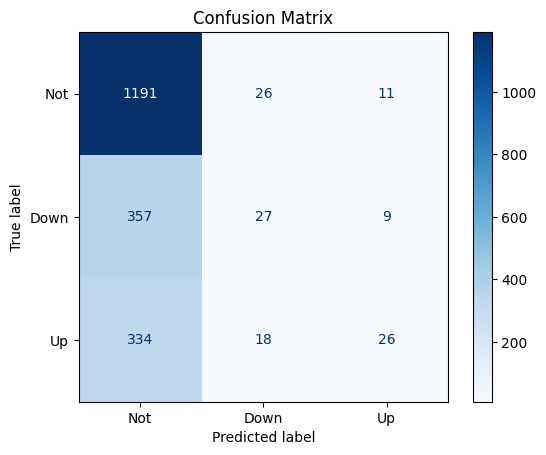

In [41]:
def create_dataset(df, rs, sequence_length):
    x = []
    y = []
    for point in rs:
        index = point[0]
        
        x_array = df_all.iloc[index-sequence_length:index].values[:,1:].astype(np.float32)
        
        min_vol = np.min(x_array[:,-1])
        max_vol = np.max(x_array[:,-1])
        if min_vol == 0:
            continue

        # x_array[:,-1] = (x_array[:,-1]-min_vol)/(max_vol-min_vol)
        x_array[:,-1] = x_array[:,-1]/min_vol

        min_price = np.min(x_array[:,:4])
        max_price = np.max(x_array[:,:4])
        x_array[:,:4] = (x_array[:,:4] - min_price) / (max_price - min_price)
        x.append(x_array)

        if point[-1] == "low":
            y.append(1)
        elif point[-1] == "high":
            y.append(2)
        else:
            y.append(0)
    return x, y

x, y = create_dataset(df_all, rs, 40)
x = np.array(x)
y = np.array(y)
x = x.reshape(x.shape[0], -1)
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

dtrain = xgb.DMatrix(x_train, label=y_train)
dtest = xgb.DMatrix(x_test, label=y_test)


param = {
    'max_depth': 25,
    'eta': 0.1,
    'objective': 'multi:softmax',  # Multiclass classification
    'num_class': 3,                # Number of classes
    'eval_metric': 'merror'       # Multiclass classification error rate
}
watchlist = [(dtrain, 'train'), (dtest, 'eval')]

# Train the model
num_round = 50
bst = xgb.train(param, dtrain, num_round, evals=watchlist, verbose_eval=False)

# Make predictions
y_pred_prob = bst.predict(dtest)
y_pred = y_pred_prob.astype(int) # Convert predicted probabilities to class labels

# Calculate accuracy
accuracy = accuracy_score(y_test, y_pred)
print(f'Accuracy: {accuracy * 100:.2f}%')

precision = precision_score(y_test, y_pred, average=None)
recall = recall_score(y_test, y_pred, average=None)
f1 = f1_score(y_test, y_pred, average=None)

print("Precision per class:", precision)
print("Recall per class:", recall)
print("F1-score per class:", f1)

# Confusion matrix
cm = confusion_matrix(y_test, y_pred)
cmd = ConfusionMatrixDisplay(cm, display_labels=['Not', 'Down', "Up"])
cmd.plot(cmap=plt.cm.Blues)
plt.title("Confusion Matrix")
plt.show()

In [45]:
from sklearn.model_selection import GridSearchCV
from xgboost import XGBRegressor

xgb = XGBRegressor()

param_grid = {
    'max_depth': [15, 20, 25],
    'learning_rate': [0.01, 0.1, 0.2],
    'n_estimators': [50, 100, 200],
    'subsample': [0.8, 1.0],
    'objective': ['multi:softmax'],  
    'num_class': [3], 
}

grid_search = GridSearchCV(estimator=xgb, param_grid=param_grid, scoring='accuracy', cv=3)
grid_search.fit(x_train, y_train)

print("Best parameters:", grid_search.best_params_)
print("Best score: ", grid_search.best_score_)


Best parameters: {'learning_rate': 0.1, 'max_depth': 15, 'n_estimators': 50, 'num_class': 3, 'objective': 'multi:softmax', 'subsample': 1.0}
Best score:  0.6325075075075075


In [ ]:
precision_weighted = precision_score(y_test, y_pred, average='weighted')
recall_weighted = recall_score(y_test, y_pred, average='weighted')
f1_weighted = f1_score(y_test, y_pred, average='weighted')

print("\nWeighted Precision:", precision_weighted)
print("Weighted Recall:", recall_weighted)
print("Weighted F1-score:", f1_weighted)

In [34]:
df['SMA'] = df['close'].rolling(window=30).mean()

# Phân loại xu hướng
# Ngưỡng cho trạng thái "không thay đổi" (dựa trên % sai lệch so với SMA)
threshold = 0.03

def classify_trend(row):
    if pd.isna(row['SMA']):
        return None  # Không đủ dữ liệu để phân loại
    elif row['close'] > row['SMA'] * (1 + threshold):
        return 2
    elif row['close'] < row['SMA'] * (1 - threshold):
        return 1
    else:
        return 0

df['Trend'] = df.apply(classify_trend, axis=1)

In [40]:
x = []
y = []
y_pred_ma = []
import random
for point in rs:
    index = point[0]
    # y_pred_ma.append(df.iloc[index]['Trend'])
    y_pred_ma.append(random.randint(0,2))
    if point[-1] == "low":
        y.append(1)
    elif point[-1] == "high":
        y.append(2)
    else:
        y.append(0)

accuracy = accuracy_score(y, y_pred_ma)
print(f'Accuracy: {accuracy * 100:.2f}%')
precision_weighted = precision_score(y, y_pred_ma, average='weighted')
recall_weighted = recall_score(y, y_pred_ma, average='weighted')
f1_weighted = f1_score(y, y_pred_ma, average='weighted')

print("\nWeighted Precision:", precision_weighted)
print("Weighted Recall:", recall_weighted)
print("Weighted F1-score:", f1_weighted)

Accuracy: 33.49%

Weighted Precision: 0.45961864069665337
Weighted Recall: 0.3349014112701431
Weighted F1-score: 0.36282039850745357


# Inference


In [ ]:
bst = xgb.Booster()
bst.load_model('./ORDIUSDT_15m_tp3_sl3_60pcent_mancond_fapiv1.json')


In [ ]:
df_all = pd.read_csv("./data_his/ORDIUSDT_2024-5-22_2024-10-23_15m_fapiv1.csv")
# df_all = df_all.iloc[-6000:].reset_index()
display(df_all.head(1))
display(df_all.tail(2)) 

rs2, idcond, high_check, low_check, list_reward, prices_list = rule(df_all, df_all, tp=3, sl=3, model=bst, num_random=213, window_test=1, seq=30, time_pred=10,manual_cond=True)
list_reward[-1]


In [ ]:
import matplotlib.pyplot as plt


fig, ax1 = plt.subplots()

ax1.plot(list_reward, 'b-', label='list_reward')
ax1.set_xlabel('time')
ax1.set_ylabel('list_reward', color='b')
ax1.tick_params(axis='y', labelcolor='b')

ax2 = ax1.twinx()
ax2.plot(prices_list, 'r-', label='prices_list')
ax2.set_ylabel('prices_list', color='r')
ax2.tick_params(axis='y', labelcolor='r')


fig.legend(loc='upper left', bbox_to_anchor=(0.1, 0.9))

# plt.title('Two Lists with Different Scales')
plt.show()

In [74]:
def round_down_to_last_15(time_str):
    time_obj = datetime.strptime(time_str,  "%Y-%m-%d %H:%M:%S")
    minutes_to_subtract = time_obj.minute % 15
    rounded_time = time_obj - timedelta(minutes=minutes_to_subtract, seconds=time_obj.second)
    
    return rounded_time.strftime( "%Y-%m-%d %H:%M:%S")
def substract7(time_str):
    time_obj = datetime.strptime(time_str, "%Y-%m-%d %H:%M:%S")

    # Add 7 hours
    new_time_obj = time_obj - timedelta(hours=7)

    # Convert back to string
    new_time_str = new_time_obj.strftime("%Y-%m-%d %H:%M:%S")
    return new_time_str

In [37]:
test_df10 = pd.read_csv("./ORDIUSDT_2024-10.csv")
test_df11 = pd.read_csv("./ORDIUSDT_2024-11.csv")

time_test10 = test_df10[test_df10['manual']==False]['time'].to_list()
time_test11 = test_df11[test_df11['manual']==False]['time'].to_list()

time_test10 = [round_down_to_last_15(i) for i in time_test10]
time_test11 = [round_down_to_last_15(i) for i in time_test11]

time_test = time_test10 + time_test11


In [ ]:
gap = 0
for rs in rs2:
    rs = list(rs)
    time_obj = datetime.strptime(rs[1], "%Y-%m-%d %H:%M:%S")

    # Add 7 hours
    new_time_obj = time_obj - timedelta(hours=7)

    # Convert back to string
    new_time_str = new_time_obj.strftime("%Y-%m-%d %H:%M:%S")
    rs[1] = new_time_str
    print(rs)
    # if new_time_str not in time_test:
    #     
    #     if len(rs) == 7:
    #         gap+=rs[-1]
    #     elif rs[-1] == 'low':
    #         gap+=30


In [ ]:
time_rs = [substract7(round_down_to_last_15(i[1])) for i in rs2]
time_rs

In [ ]:
for dt in test_df10.itertuples(index=True, name='Pandas'):
    if dt.manual:
        continue

    if round_down_to_last_15(dt.time) not in time_rs:
        print(dt.time, round(dt.askPrice,3), round(dt.pnl,3))

In [83]:
sumpnl_manual = test_df10['pnl'].sum()


In [ ]:
df = pd.read_csv("./data_his/ORDIUSDT_2024-08-11_2024-09-03_15m.csv")
df.rename(columns={'volumn': 'volume'}, inplace=True)

df.set_index('timestamp', inplace=True)
df.index = pd.to_datetime(df.index)


In [ ]:
import mplfinance as mpf


mpf.plot(df, type='candle', style='charles', volume=False, title=f"K-Line Chart", ylabel='Price (USDT)', figratio=(15, 8),  figscale=1)